In [249]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
from matplotlib.lines import lineStyles
import requests
import time
import csv
import pandas as pd
import seaborn as sns

In [250]:
pH = ctrl.Antecedent(np.arange(0, 15, 0.1), 'pH')
pH['Low'] = fuzz.trimf(pH.universe, [0, 0, 7])
pH['Optimal'] = fuzz.trimf(pH.universe, [6, 7, 8])
pH['High'] = fuzz.trimf(pH.universe, [7, 14, 14])

airTemp = ctrl.Antecedent(np.arange(0, 46, 1), 'AirTemp')
airTemp['Low'] = fuzz.trimf(airTemp.universe, [0, 0, 15])
airTemp['Optimal'] = fuzz.trimf(airTemp.universe, [10, 15, 20])
airTemp['High'] = fuzz.trimf(airTemp.universe, [15, 45, 45])

humidity = ctrl.Antecedent(np.arange(0,101,1), 'Humidity')
humidity['Low'] = fuzz.trimf(humidity.universe, [0, 0, 60])
humidity['Optimal'] = fuzz.trimf(humidity.universe, [50, 60, 70])
humidity['High'] = fuzz.trimf(humidity.universe, [60, 100, 100])

conductivity = ctrl.Antecedent(np.arange(0, 5.1, 0.1), 'Conductivity')
conductivity['Low'] = fuzz.trimf(conductivity.universe, [0, 0, 2.1])
conductivity['Optimal'] = fuzz.trimf(conductivity.universe, [1.8, 2.1, 2.3])
conductivity['High'] = fuzz.trimf(conductivity.universe, [2.1, 5, 5])

In [251]:
lights = ctrl.Consequent(np.arange(0, 4, 1), 'Lights')
lights['Off'] = fuzz.trimf(lights.universe, [0,0,1])
lights['Low'] = fuzz.trimf(lights.universe, [1,1,2])
lights['Medium'] = fuzz.trimf(lights.universe, [1,2,3])
lights['High'] = fuzz.trimf(lights.universe, [2,3,3])

fans = ctrl.Consequent(np.arange(0, 2, 1), 'Fans')
fans['Off'] = fuzz.trimf(fans.universe, [0,0,1])
fans['On'] = fuzz.trimf(fans.universe, [1,1,2])

pH_control = ctrl.Consequent(np.arange(0, 3, 1), 'pH Control')
pH_control['Add Acid'] = fuzz.trimf(pH_control.universe, [0,0,1])
pH_control['No Action'] = fuzz.trimf(pH_control.universe, [0,1,2])
pH_control['Add Alkali'] = fuzz.trimf(pH_control.universe, [1,2,2])

solution_control = ctrl.Consequent(np.arange(0, 3, 1), 'Solution Control')
solution_control['Add Salts'] = fuzz.trimf(solution_control.universe, [0,0,1])
solution_control['No Action'] = fuzz.trimf(solution_control.universe, [0,1,2])
solution_control['Add Water'] = fuzz.trimf(solution_control.universe, [1,2,2])

In [252]:
# Rules for Air temp and Humidity to adjust lights and fans
rule1 = ctrl.Rule(airTemp['Low'] & humidity['Low'], (lights['High'], fans['Off']))
rule2 = ctrl.Rule(airTemp['Optimal'] & humidity['Low'], (lights['Medium'], fans['Off']))
rule3 = ctrl.Rule(airTemp['High'] & humidity['Low'], (lights['Off'], fans['Off']))

rule4 = ctrl.Rule(airTemp['Low'] & humidity['Optimal'], (lights['Medium'], fans['Off']))
rule5 = ctrl.Rule(airTemp['Optimal'] & humidity['Optimal'], (lights['Low'], fans['Off']))
rule6 = ctrl.Rule(airTemp['High'] & humidity['Optimal'], (lights['Off'], fans['Off']))

rule7 = ctrl.Rule(airTemp['Low'] & humidity['High'], (lights['High'], fans['On']))
rule8 = ctrl.Rule(airTemp['Optimal'] & humidity['High'], (lights['Medium'], fans['On']))
rule9 = ctrl.Rule(airTemp['High'] & humidity['High'], (lights['Off'], fans['On']))

# Rules for pH
rule10 = ctrl.Rule(pH['Low'], pH_control['Add Alkali'])
rule11 = ctrl.Rule(pH['Optimal'], pH_control['No Action'])
rule12 = ctrl.Rule(pH['High'], pH_control['Add Acid']) 

# Rules for conductivity
rule13 = ctrl.Rule(conductivity['Low'], solution_control['Add Salts'])
rule14 = ctrl.Rule(conductivity['Optimal'], solution_control['No Action'])
rule15 = ctrl.Rule(conductivity['High'], solution_control['Add Water']) 

rules = [rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10, rule11, rule12, rule13, rule14, rule15]
hydroponics_ctrl = ctrl.ControlSystem(rules)
ctrlSim = ctrl.ControlSystemSimulation(hydroponics_ctrl)

def run(airTemp_reading, humidity_reading, pH_reading, ec_reading):
        ctrlSim.input['AirTemp'] = airTemp_reading
        ctrlSim.input['Humidity'] = humidity_reading
        ctrlSim.input['pH'] = pH_reading
        ctrlSim.input['Conductivity'] = ec_reading
        ctrlSim.compute()

def getResults():
    lights_change = ctrlSim.output['Lights']
    lights_str = 'Off' if lights_change < 0.5 else 'Low' if lights_change < 1.5 else 'Medium' if lights_change < 2.5 else 'High'

    fans_change = ctrlSim.output['Fans']
    fans_str = 'Off' if fans_change < 0.5 else 'On'

    pH_change = ctrlSim.output['pH Control']
    pH_str = 'Add Acid' if pH_change < 0.5 else 'No Action' if pH_change < 1.5 else 'Add Alkali'

    ec_change = ctrlSim.output['Solution Control']
    ec_str = 'Add Salts' if ec_change < 0.5 else 'No Action' if ec_change < 1.5 else 'Add Water'

    return [lights_change, fans_change, pH_change, ec_change, lights_str, fans_str, pH_str, ec_str]

In [253]:
colnames=['time', 'id', 'AirTemperature'] 
df_air = pd.read_csv('./Test data/AirTemperature.csv', names=colnames, skiprows=1)
df_air.head()

,time,id,AirTemperature
0,2020-10-08 19:42:16 UTC,373505,75.2
1,2020-10-08 19:42:45 UTC,373506,75.2
2,2020-10-08 19:43:14 UTC,373507,53.6
3,2020-10-08 19:43:44 UTC,373508,75.2
4,2020-10-08 19:44:13 UTC,373509,75.2


In [254]:
colnames=['time', 'id', 'Humidity'] 
df_humid = pd.read_csv('./Test data/Humidity.csv', names=colnames, skiprows=1)
df_humid.head()

,time,id,Humidity
0,2020-10-08 19:42:16 UTC,373505,21.0
1,2020-10-08 19:42:45 UTC,373506,21.0
2,2020-10-08 19:43:14 UTC,373507,138.0
3,2020-10-08 19:43:44 UTC,373508,21.0
4,2020-10-08 19:44:13 UTC,373509,21.0


In [255]:
colnames=['time', 'id', 'pH'] 
df_pH = pd.read_csv('./Test data/pH.csv', names=colnames, skiprows=1)
df_pH.head()

,time,id,pH
0,2020-10-08 19:42:16 UTC,373505,4.142
1,2020-10-08 19:42:45 UTC,373506,4.138
2,2020-10-08 19:43:14 UTC,373507,4.140
3,2020-10-08 19:43:44 UTC,373508,4.146
4,2020-10-08 19:44:13 UTC,373509,4.139


In [256]:
colnames=['time', 'id', 'Conductivity'] 
df_ec = pd.read_csv('./Test data/Conductivity.csv', names=colnames, skiprows=1)
df_ec.head()

,time,id,Conductivity
0,2020-10-08 19:42:16 UTC,373505,0.01504
1,2020-10-08 19:42:45 UTC,373506,0.01514
2,2020-10-08 19:43:14 UTC,373507,0.01494
3,2020-10-08 19:43:44 UTC,373508,0.01514
4,2020-10-08 19:44:13 UTC,373509,0.01504


In [257]:
df = pd.concat([df_air['AirTemperature'], df_humid['Humidity'], df_pH['pH'], df_ec['Conductivity']], axis=1)
df.shape

(100, 4)

In [258]:
df.head()

,AirTemperature,Humidity,pH,Conductivity
0,75.2,21.0,4.142,0.01504
1,75.2,21.0,4.138,0.01514
2,53.6,138.0,4.140,0.01494
3,75.2,21.0,4.146,0.01514
4,75.2,21.0,4.139,0.01504


In [259]:
df['AirTemperature'] = (df['AirTemperature']-32)/1.8
df['Conductivity'] = df['Conductivity']*100
df.head()

,AirTemperature,Humidity,pH,Conductivity
0,24.0,21.0,4.142,1.504
1,24.0,21.0,4.138,1.514
2,12.0,138.0,4.140,1.494
3,24.0,21.0,4.146,1.514
4,24.0,21.0,4.139,1.504


In [260]:
results = pd.DataFrame(columns=['Air Temperature','Humidity','pH', 'Conductivity', 'Lights Membership', 'Fans Membership', 'pH Membership', 'EC Membership', 'Lights Status', 'Fans Status', 'pH Control Status', 'EC Control Status'])
results.head()

,Air Temperature,Humidity,pH,Conductivity,Lights Membership,Fans Membership,pH Membership,EC Membership,Lights Status,Fans Status,pH Control Status,EC Control Status


In [261]:
i = 0

for index, row in df.iterrows():
    run(row[0], row[1], row[2], row[3])
    results.loc[i] = np.concatenate((row, getResults()))
    i = i + 1
    ctrlSim.reset()

results.shape

(100, 12)

In [262]:
results.head()

,Air Temperature,Humidity,pH,Conductivity,Lights Membership,Fans Membership,pH Membership,EC Membership,Lights Status,Fans Status,pH Control Status,EC Control Status
0,24.0,21.0,4.142,1.504,0.4294117647058823,0.4294117647058823,1.5933440862972366,0.4329587935803252,Off,Off,Add Alkali,Add Salts
1,24.0,21.0,4.138,1.514,0.4294117647058823,0.4294117647058823,1.5934593540774182,0.43400866120290577,Off,Off,Add Alkali,Add Salts
2,12.0,138.0,4.14,1.494,2.0509803921568626,0.5916666666666667,1.593401726938531,0.43191191668654105,Medium,On,Add Alkali,Add Salts
3,24.0,21.0,4.146,1.514,0.4294117647058823,0.4294117647058823,1.5932287645364982,0.43400866120290577,Off,Off,Add Alkali,Add Salts
4,24.0,21.0,4.139,1.504,0.4294117647058823,0.4294117647058823,1.5934305421962303,0.4329587935803252,Off,Off,Add Alkali,Add Salts


In [265]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Air Temperature    100 non-null    object
 1   Humidity           100 non-null    object
 2   pH                 100 non-null    object
 3   Conductivity       100 non-null    object
 4   Lights Membership  100 non-null    object
 5   Fans Membership    100 non-null    object
 6   pH Membership      100 non-null    object
 7   EC Membership      100 non-null    object
 8   Lights Status      100 non-null    object
 9   Fans Status        100 non-null    object
 10  pH Control Status  100 non-null    object
 11  EC Control Status  100 non-null    object
dtypes: object(12)
memory usage: 10.2+ KB


In [268]:
results['Air Temperature'] = results['Air Temperature'].astype('float64')
results['Humidity'] = results['Humidity'].astype('float64')
results['pH'] = results['pH'].astype('float64')
results['Conductivity'] = results['Conductivity'].astype('float64')

<AxesSubplot:xlabel='pH Control Status', ylabel='pH'>

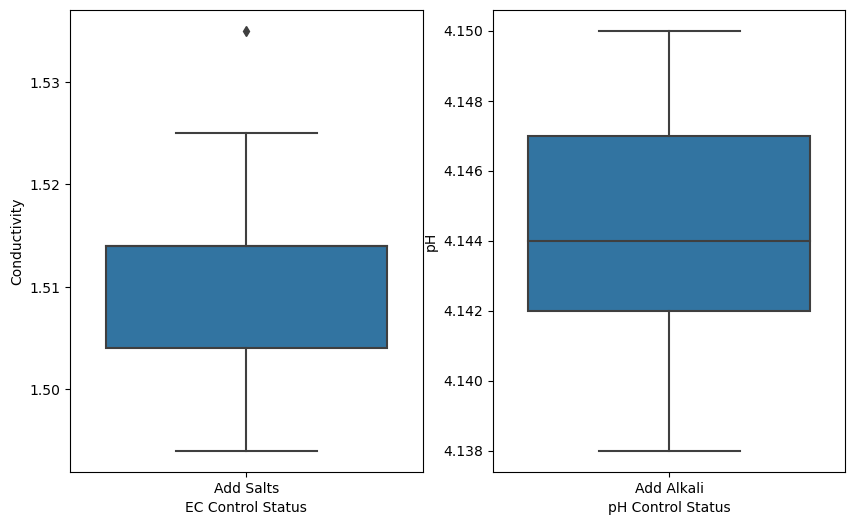

In [272]:
fig, axs = plt.subplots(ncols=2, figsize=(10,6))
sns.boxplot(x=results['EC Control Status'], y=results['Conductivity'], data=results, ax=axs[0])
sns.boxplot(x=results['pH Control Status'], y=results['pH'], data=results, ax=axs[1])

<AxesSubplot:xlabel='Air Temperature', ylabel='Humidity'>

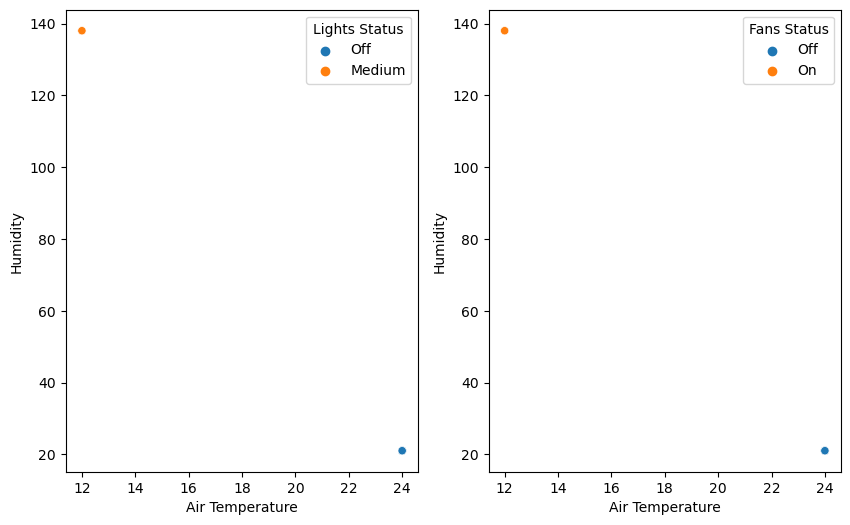

In [271]:
fig, axs = plt.subplots(ncols=2, figsize=(10,6))
sns.scatterplot(y='Humidity', x='Air Temperature', hue='Lights Status', data=results, ax=axs[0])
sns.scatterplot(y='Humidity', x='Air Temperature', hue='Fans Status', data=results, ax=axs[1])